In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook', font_scale=1.3)

from agents import Agent
from mouselab import MouselabEnv
from distributions import Normal, Categorical
from policies import FixedPlanPolicy, LiederPolicy

import warnings
warnings.filterwarnings("ignore", 
                        message="The objective has been evaluated at this point before.")

In [2]:
from bandits import MetaBanditEnv
from evaluation import *

In [6]:
# pol = LiederPolicy([1,0,0,1,1])
pol = LiederPolicy([5.939, 0.715, 0.603, 0.545, 1.])
env = MetaBanditEnv(25, 30, 0.001)
envs = [env] * 1000
def test():
    print(get_util(pol, envs))

%time test()

0.75442860514
CPU times: user 31.5 s, sys: 659 ms, total: 32.2 s
Wall time: 31.4 s


In [69]:
%%time
env = MetaBanditEnv(5, 10, .01)
optimal_policy(env)

optimal -> 0.5785547555582277 in 0.37857593409717083 sec
CPU times: user 380 ms, sys: 128 µs, total: 380 ms
Wall time: 379 ms


In [68]:
%%time
env = MetaBanditEnv(12, 30, .01)
train_envs = [env] * 500
pol, result = bo_policy(train_envs, max_cost=30, n_jobs=5, n_calls=20, 
                        verbose=0, normalize_voi=False, return_result=True)

from skopt.plots import plot_convergence, plot_evaluations, plot_objective
plot_convergence(result)
# plot_objective(result)

Exception ignored in: <function WeakValueDictionary.__init__.<locals>.remove at 0x7f005a3bf0d0>
Traceback (most recent call last):
  File "/home/fredcallaway/miniconda3/lib/python3.6/weakref.py", line 109, in remove
    def remove(wr, selfref=ref(self), _atomic_removal=_remove_dead_weakref):
KeyboardInterrupt
Process ForkPoolWorker-662:
Process ForkPoolWorker-663:
Process ForkPoolWorker-661:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/fredcallaway/miniconda3/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/home/fredcallaway/miniconda3/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/home/fredcallaway/miniconda3/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/home/fredcallaway/miniconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwarg

KeyboardInterrupt: 

In [ ]:
def run_params(n_arm, max_obs=30, cost=.01):
    env = MetaBanditEnv(n_arm, max_obs, cost)
    train_envs = [env] * 500
    term_action = train_envs[0].term_action
    policies = {
        'BO': bo_policy(train_envs, max_cost=max_obs, n_calls=30),
        # 'BO_unnorm': bo_policy(train_envs, normalize_voi=False, max_cost=max_obs, n_calls=60),
        'meta-greedy': LiederPolicy([1, 1, 0, 0, 1]),
        'blinkered': blinkered_policy(env),
        # 'optimal': optimal_policy(env),
        'full-observation': LiederPolicy([-100, 0.5, 0.5, 0, 1]),
        # 'none': FixedPlanPolicy([term_action]),
    }
    test_envs = [env] * 500
    def test():
        for name, policy in policies.items():
            df = evaluate(policy, envs=test_envs)
            df['agent'] = name
            df['n_arm'] = n_arm
            df['max_obs'] = max_obs
            df['cost'] = cost
            yield df
    return pd.concat(test())
    
all_data = []
for n_arm in (8, 12, 16, 20):
    print('-----', n_arm, '------')
    data = Parallel(n_jobs=7)(delayed(run_params)(n_arm, cost=cost) 
                           for cost in np.logspace(-4, -1, 7))
    all_data.append(data)

# df = pd.concat(data)
# df = run_params(4, 20, cost=.01)

----- 8 ------
BO: [ 4.531  0.374  0.     0.626  1.   ] -> 0.121 in 105 sec
blinkered -> 0.06666666666666662 in 0.04129414795897901 sec
BO: [ 7.833  0.367  0.     0.633  1.   ] -> 0.454 in 176 sec
blinkered -> 0.4877517830878194 in 0.04030784894712269 sec
BO: [ 4.053  0.192  0.404  0.404  1.   ] -> 0.633 in 269 sec
blinkered -> 0.6597007163466211 in 0.040064381901174784 sec
BO: [ 4.225  0.273  0.151  0.576  1.   ] -> 0.767 in 337 sec
blinkered -> 0.7713937583104218 in 0.03824019804596901 sec
BO: [ 1.    0.21  0.17  0.62  1.  ] -> 0.838 in 359 sec
blinkered -> 0.8306787659552629 in 0.04318963992409408 sec
BO: [ 4.43   0.37   0.083  0.547  1.   ] -> 0.827 in 380 sec
blinkered -> 0.8395737526028373 in 0.04229553206823766 sec
BO: [ 16.134   0.285   0.182   0.533   1.   ] -> 0.842 in 389 sec
blinkered -> 0.8380337943449786 in 0.04045109311118722 sec
----- 12 ------
BO: [ 4.364  0.459  0.     0.541  1.   ] -> 0.174 in 136 sec
blinkered -> 0.18888888888888883 in 0.0452081928960979 sec
BO: [ 3

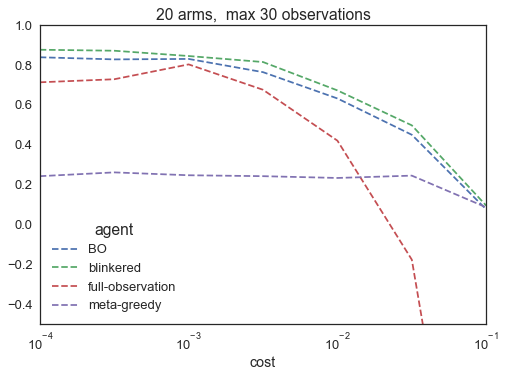

In [72]:
(df
 .query('n_arm == 8')
 .groupby('cost agent'.split())
 .util.mean().unstack()
 .plot(logx=True, ls='--', by='n_arm'))
plt.ylim(-.5,1)
plt.title('20 arms,  max 30 observations')

12.425000000000001

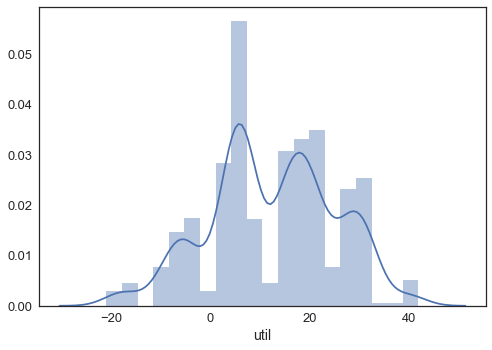

In [62]:
sns.distplot(df.query('agent == "BO"').util)
df.query('agent == "BO"').util.mean()

In [16]:
env = MetaBanditEnv(5, 20, 0.01)
policy = LiederPolicy([1,1,1,1,1])
agent = Agent()
agent.register(env)
agent.register(policy)

def test():
    tr = agent.run_episode()
    print(len(tr['actions']))

%prun test()

21
 